# Анализ текстовых данных. Часть 2
# Тематическое моделирование

---

- посмотрим на магию
    - интуиция
    - проект вк
- разберем теорию
    - разложение матриц
    - байес
    - тематическое моделирование
- примеры с кодом
    - NMF, LDA

https://en.wikipedia.org/wiki/File:Topic_model_scheme.webm

---

## Наивный байесовский классификатор

$Def$:

* $t$ - тема
* $T$ - набор тем
* $w_i$ - токен/слово/терм
* $d$ - документ

**Имеем:**

$$ t = argmax_{t \in T} p(w_1, w_2, ..., w_n | T(d) = t) \cdot p(T(d) = t) \simeq $$
$$ \simeq p(w_1 | T(d) = t) \cdot ... \cdot p(w_n | T(d) = t) \cdot p(T(d) = t) $$

**Пример:**

$d$ = [Чемпионат мира по футболу]

$T$ = {новости, спорт, финансы}

**Проблемы:**

1. Наивность
2. Датасет
3. Одна метка


---
https://habr.com/en/company/surfingbird/blog/150207/ [наивный байесовский классификатор]

https://habr.com/ru/company/surfingbird/blog/228249/ [LDA ч1]

https://habr.com/ru/company/surfingbird/blog/230103/ [LDA ч2]

---

# Тематическое моделирование

Тема - это семантически однородный кластер текстов, характеризующийся специализированной терминологией.

Тематическая модель автоматически определяет, к каким темам относится каждый документ из коллекции документов, а также какие слова (термины) характеризуют каждую тему.

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d5/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.png">

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных.

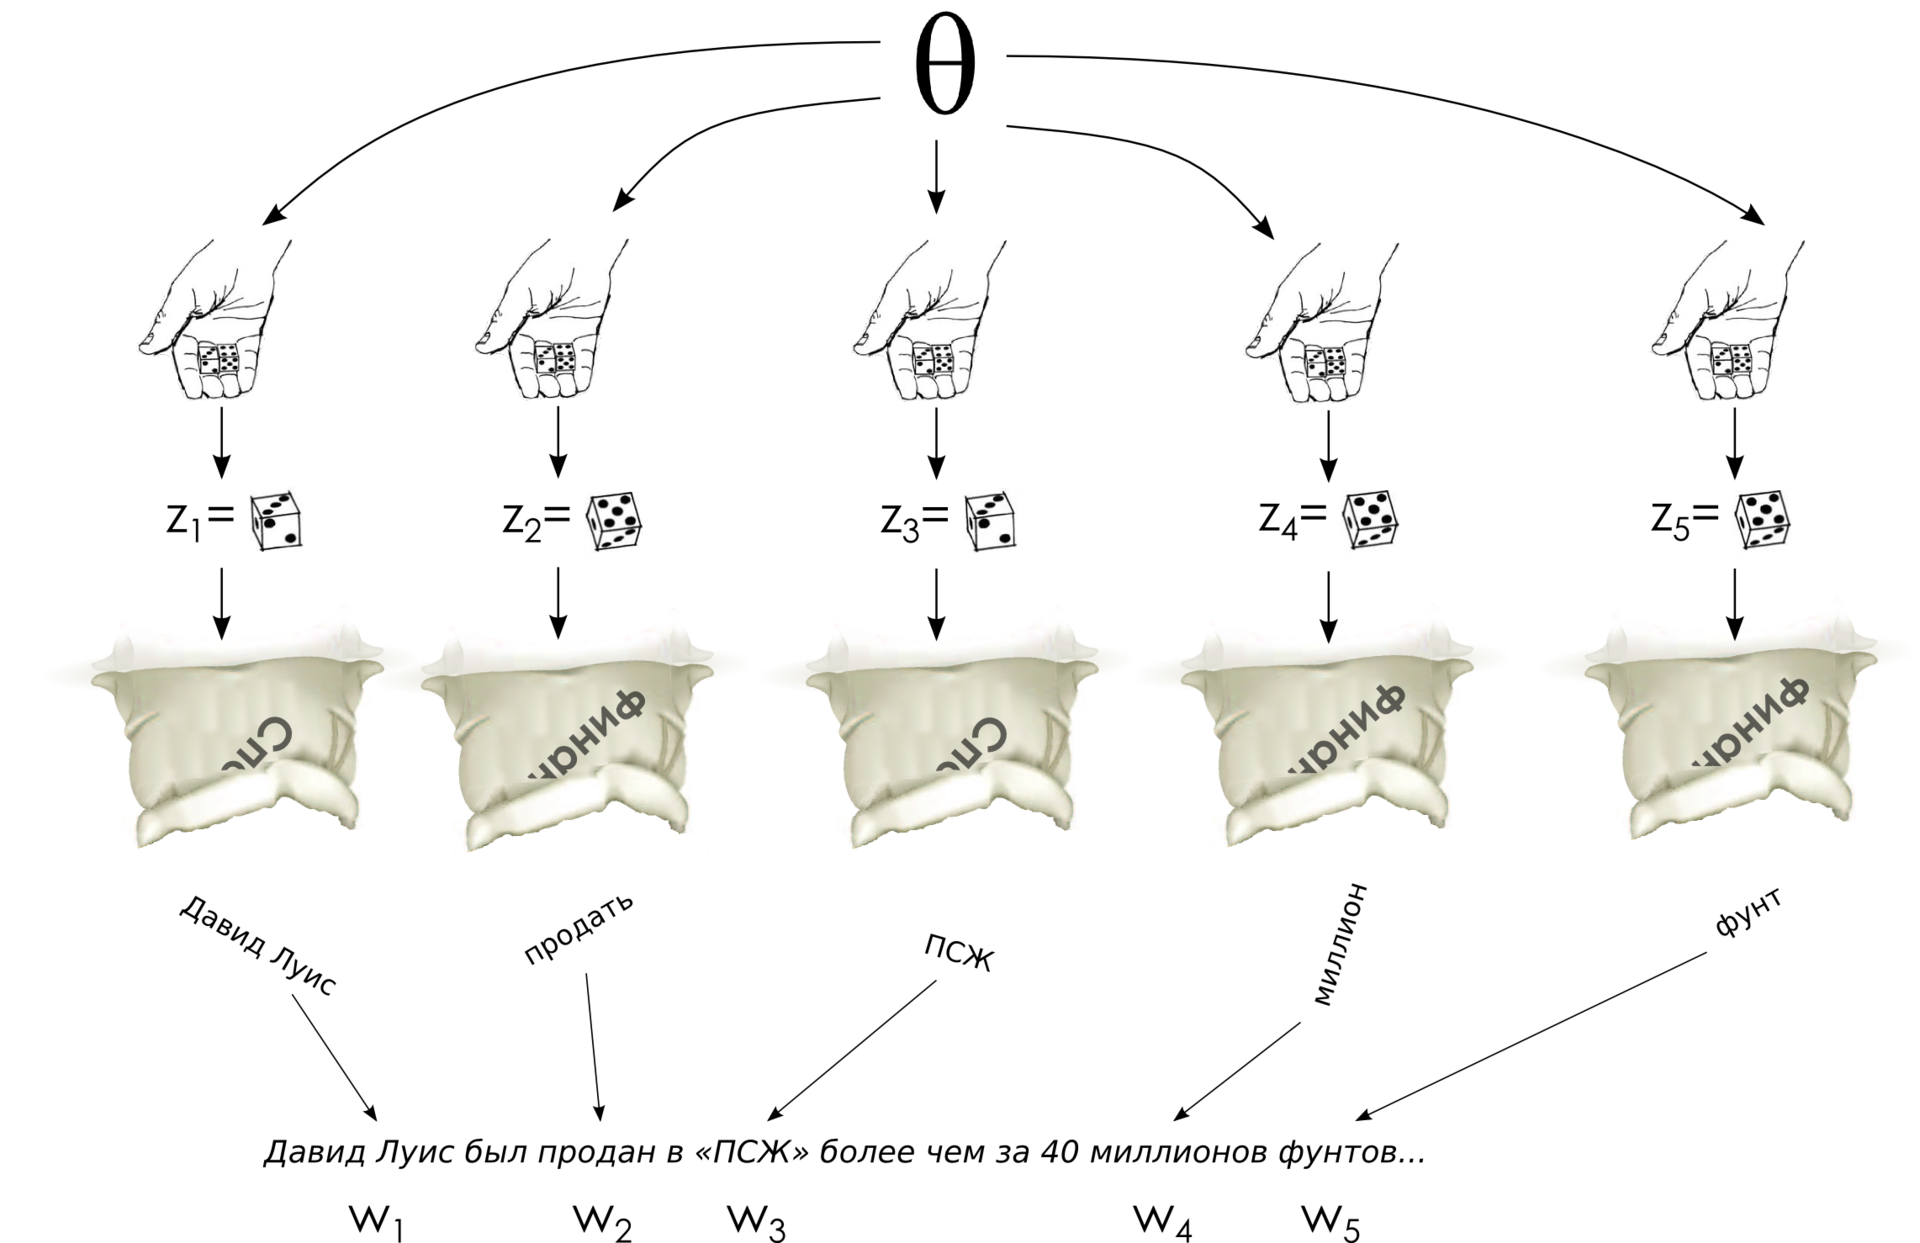

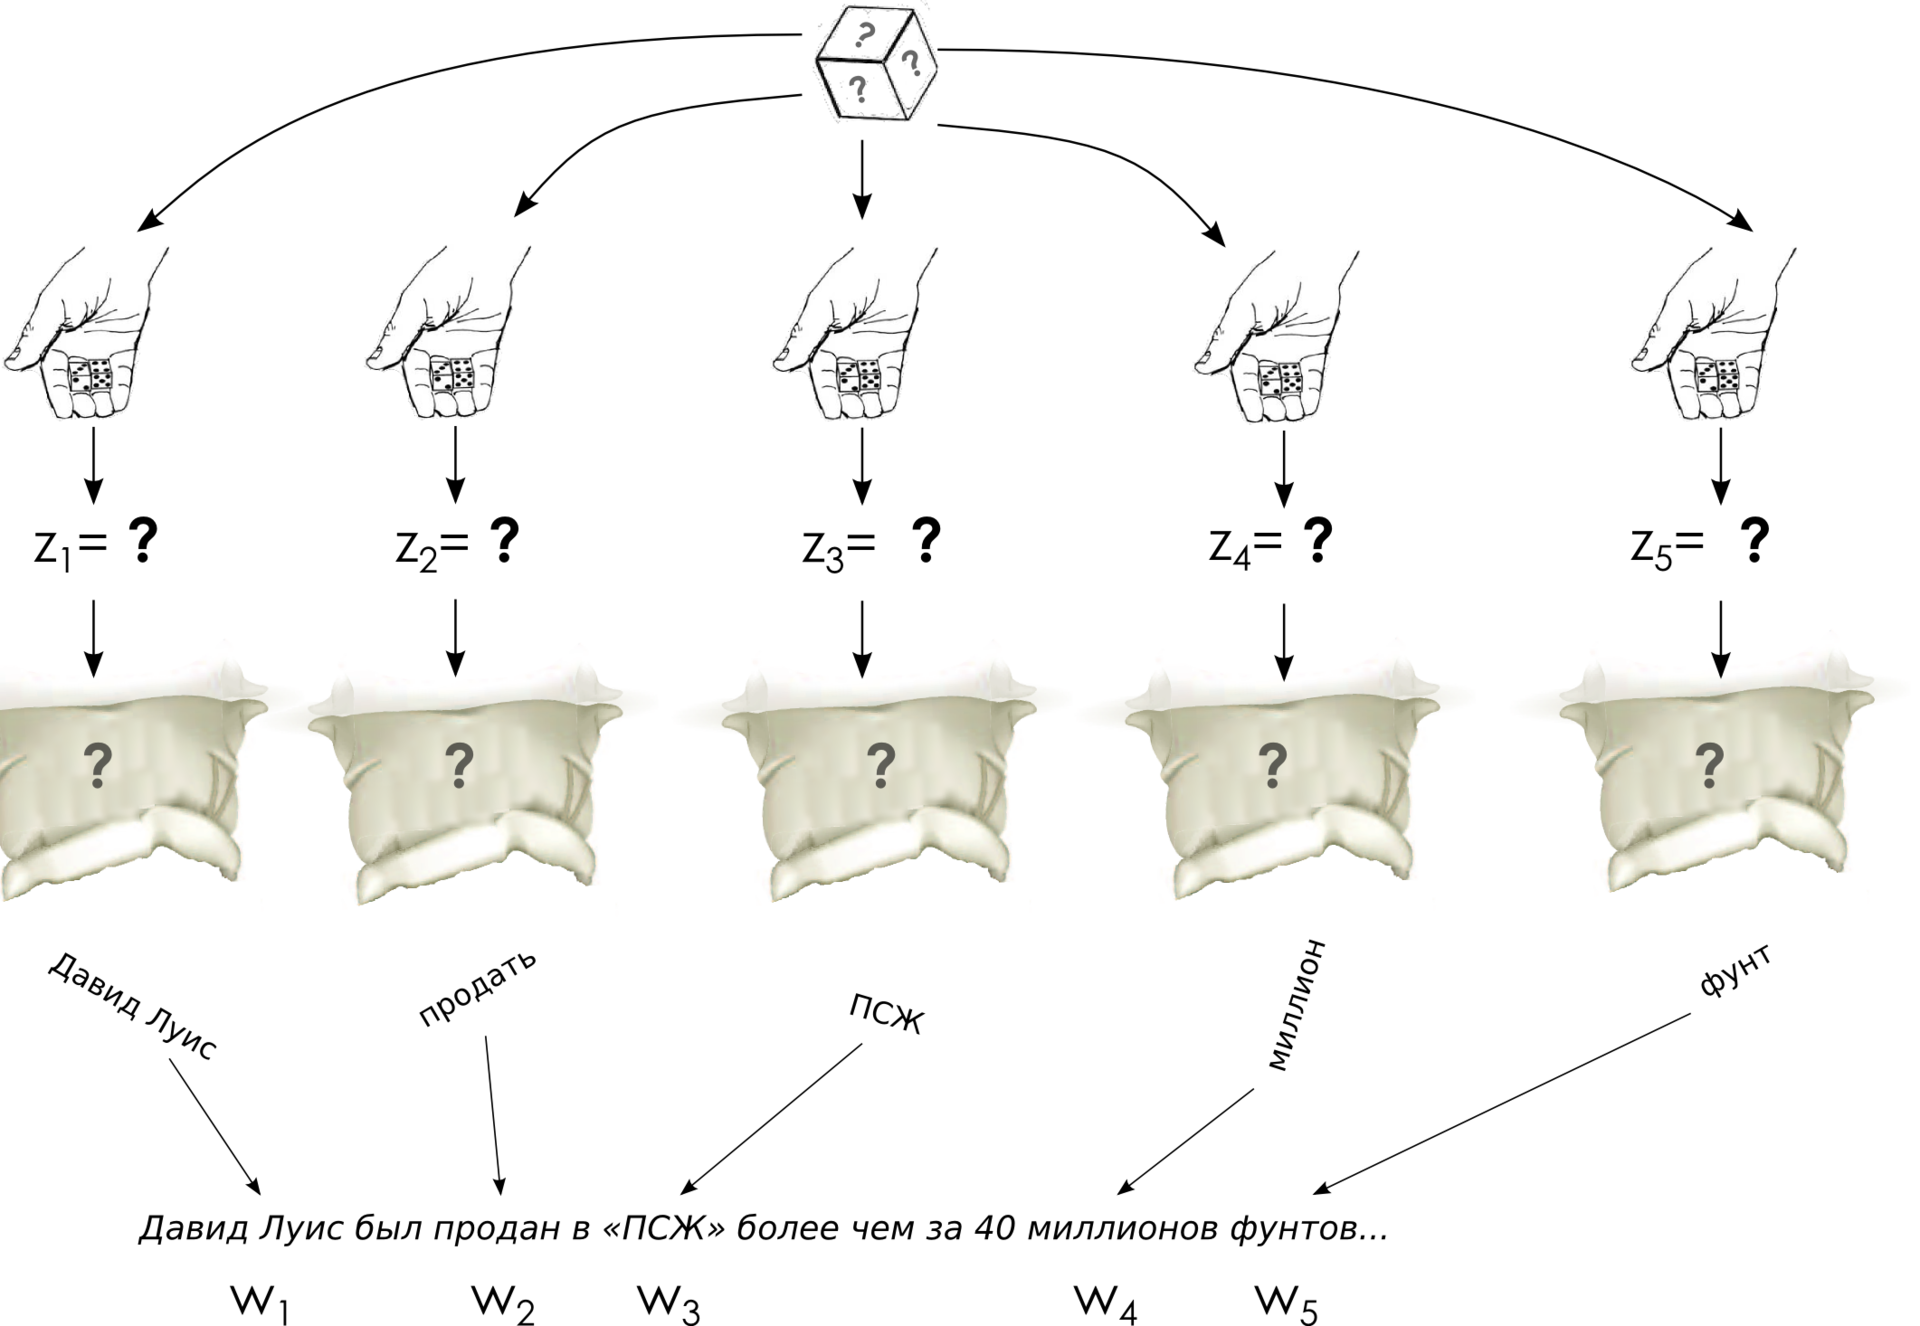

---
---
---
---
---
---
---
---

## Гипотезы тематического моделирования
- порядок слов в документе не важен
- порядок документов в коллекции не важен
- каждый терм w в документе связан с некоторой темой
- гипотеза условной независимости:
$$p(w|d,t) = p(w|t)$$

Еще раз про конечную цель:

* автоматически выделить топики $T$
* интерпретировать топики по $w \in T$
* уметь быстро понимать о чем текст по $t \in D$

In [2]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

Load the 20 newsgroups dataset and vectorize it. We use a few heuristics to filter out useless terms early on: the posts are stripped of headers, footers and quoted replies, and common English words, words occurring in only one document or in at least 95% of the documents are removed.

In [3]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))

In [4]:
dataset.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [5]:
data_samples = dataset.data
len(data_samples)

11314

In [6]:
len(dataset['target_names'])

20

In [7]:
dataset['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [8]:
data_samples[0]

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

In [9]:
dataset['target_names'][dataset['target'][0]]

'talk.politics.mideast'

In [10]:
data_samples[1]

"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

In [11]:
dataset['target_names'][dataset['target'][1]]

'alt.atheism'

In [12]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

### Use tf-idf features for NMF.

In [14]:
n_features = 1000

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [16]:
%%time
tfidf = tfidf_vectorizer.fit_transform(data_samples)

Wall time: 2.21 s


### Use tf (raw term count) features for LDA.

In [17]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

In [18]:
%%time
tf = tf_vectorizer.fit_transform(data_samples)

Wall time: 2.18 s


### Fit the NMF model

In [19]:
n_components = 10

In [20]:
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5)

In [21]:
%%time
nmf.fit(tfidf)

Wall time: 659 ms


NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
  n_components=10, random_state=1, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [22]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [23]:
n_top_words = 20
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: don just people think like know time good right ve did say really way make want said going things ll
Topic #1: card video monitor drivers cards bus vga driver color ram memory mode bit board pc controller graphics 16 apple modem
Topic #2: god jesus bible christ faith believe christian christians church sin lord life truth hell does man say belief christianity love
Topic #3: game team year games season players play hockey win player league teams nhl runs best good hit better think division
Topic #4: car new 00 sale 10 price offer condition shipping 20 used interested 50 15 30 asking old 12 sell good
Topic #5: thanks does know advance mail hi anybody info looking help appreciated information address email post interested need send appreciate like
Topic #6: windows file use files dos window program using problem running version run screen application server software pc help ms ftp
Topic #7: edu soon cs university com email internet article ftp send pub david mail mit au apr subj

### Fitting LDA models

In [24]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [25]:
%%time
lda.fit(tf)

Wall time: 34.1 s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [26]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [28]:
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: people gun armenian armenians war turkish states israel said children jews 000 state new guns israeli vs military years american
Topic #1: government people law mr use president don think right public make state going privacy private security know new rights want
Topic #2: space program output entry data nasa use science research build section center launch time high earth year rules long satellite
Topic #3: key car chip used keys bike use bit clipper number phone like cars just engine ground des algorithm good secret
Topic #4: edu file com available mail ftp files information image send list use version server email pub software cs code window
Topic #5: god people does jesus say think believe don know just way like true question life time christian did point bible
Topic #6: windows use drive thanks does problem know card like using db scsi dos disk bit need pc memory mac work
Topic #7: ax max b8f g9v a86 pl 145 1d9 0t 34u 1t 3t giz bhj wm 2di 75u 2tm cx bxn
Topic #8: just do

In [29]:
lda.components_

array([[1.03197977e-01, 3.71351204e+02, 1.11548432e-01, ...,
        5.56365604e+00, 1.72149288e+02, 7.44101756e+01],
       [1.17592487e-01, 1.04091218e-01, 1.00069609e-01, ...,
        1.16151717e+02, 7.11178897e+00, 1.00269719e-01],
       [9.18690074e+00, 7.36980863e+00, 8.92878098e+00, ...,
        2.87613192e+00, 1.49034051e-01, 1.00075326e-01],
       ...,
       [1.19368426e-01, 1.16239615e-01, 1.05411754e-01, ...,
        1.00057552e-01, 1.06259394e-01, 1.00161900e-01],
       [1.05681809e-01, 4.58678916e+01, 1.00492572e-01, ...,
        3.01590736e+02, 6.37732768e+01, 1.88298644e+02],
       [1.06484645e+03, 2.48463781e+02, 2.14078518e+02, ...,
        1.31786491e-01, 4.90524664e+01, 2.93634961e+01]])

In [30]:
lda.components_.shape

(10, 1000)

# Наивный Байес
* Знаем метку каждого документа
* У каждого документа только одна метка  


Что можно сделать, если нет информации о метках?
#### Проблема кластеризации  
Можно решать с помощью EM-алгоритма:
* E-шаг - вычислить ожидания того, какой документ к какой теме относится
* M-шаг - с помощью Наивного Байеса определить вероятности $p(w|t)$ при фиксированных метках


## EM-алгоритм

Решает задачу кластеризации.  
Подбирает некоторые параметры модели для данных в которых неизвестен ответ.  

Expectation шаг:
* зафиксировать параметры модели
* посчитать значения скрытых переменных
Maximization шаг:
* зафиксировать скрытые переменные
* посчитать параметры модели

Повторять до сходимости.

Есть математическое обоснование того, что метод сходится к локальному экстремуму, на каждом шаге значение функции правдоподобия не убывает (правдоподобие $p(\theta | \mathcal{X})$ - насколько правдоподобна модель при данных параметрах, насколько она хорошо описывает данные)

Частный случай EM-алгоритма - **k-means**.  
Метки кластеров - скрытые переменные Z  (latent variables)  
Параметры модели - центры кластеров  

Еще вариант EM-алгоритма - разделение смеси гауссиан (Gaussian Mixture Model, GMM)

Параметры модели - центр кластера и матрица ковариаций (здесь описывает форму могомерного нормального распраделения, или гауссианы)
Скрытые переменные - вероятность пренадлежности к каждой гауссиане (метка кластера выбирается как наиболее вероятный кластер)

## PLSA

Что если у каждого документа может быть много меток?

Рассмотрим модель:
* Каждое слово в документе $d$ сгенерировано из некоторой темы $t \in T$
* Документ сгенерирован некоторым распределением над темами $p(t|d)$
* Слово сгенерировано из темы (не из документа) $p(w|d, t) = p(w|d)$
* Получаем правдоподобие: $$p(w|d) = \sum_{t \in T}p(w|t)p(t|d) $$

Полученная модель - probabilistic latent semantic analysis, pLSA, Вероятностный латентно-семантический анализ

http://www.machinelearning.ru/wiki/index.php?title=%D0%92%D0%B5%D1%80%D0%BE%D1%8F%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%BD%D1%8B%D0%B9_%D0%BB%D0%B0%D1%82%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7

Обучение:  
Нам нужны величины:
* $p(w|t)$ - вероятности слов в темах, обозначим $\phi_{wt}$

* $p(t|d)$ - вероятности тем в документах, обозначим $\theta_{td}$

E-шаг:
* фиксируем $\phi_{wt}$ и $\theta_{td}$
* вычисляем $$p(t|d,w) = \frac{\phi_{wt} \theta_{td}}{\sum_{s \in T}\phi_{ws} \theta_{sd}}$$ для всех тем, для каждого документа, для каждого термина
* вычисляем количество терминов, которое генерируется в документе $d$ темой $t$ $$n_{dwt} = n_{dw}p(t|d,w)$$

М-шаг:
* по вычисленным $p(t|d,w)$ обновить приближения модели $\phi_{wt}$ и $\theta_{td}$
* $$n_{wt} = \sum_d n_{dwt}$$ $$n_{td} = \sum_{w \in d} n_{dwt}$$ $$n_t=\sum_w n_{wt}$$
* $$\theta_{td} = \frac{n_{td}}{n_d}$$ $$\phi_{wt} = \frac{n_{wt}}{n_t}$$


Можно не хранить матрицу $n_{dwt}$, а итерироваться по документам и суммировать $n_{wt}$ и $n_{td}$
* Много локальных экстремумов
* Много параметров, модель переобучается
* Нужно достичь не локальный минимум, а добиться интерпретируемости - найти "хороший" минимум

## LDA

В общем случае, чтобы улучшить pLSA, в логарифм правдоподобия добавляют регуляризацию:

$$\sum_{d \in D} \sum_{w \in d} n_{dw} ln \sum_{t \in T} \phi_{wt} \theta_{td} + \sum_i \tau_i R_i(\Phi, \Theta)$$

Если добавить априорное распределение - распределение дирехле, получим алгоритм LDA - Latent Dirichlet Allocation

В итоге получаем "хорошее" интерпретируемое решение (лучше, чем с pLSA)


Один документ может содержать несколько тем.  
Составляем иерархическую модель:  
* первый уровень - смесь, компоненты которой отвечают за темы
* второй уровень - мультиномиальная переменная с априорным распределением Дирихле, которая определяет "распределение над темами" в документе

Обучение:
* сэмплирование по Гибсу
* online variational bayes

## Cхема решения задач NLP:
1. Сбор данных:
    - API
    - crawling сайта
    - известные датасеты
    - Mechanical Turk, Toloka, etc.

2. Выбор метрики качества.

3. Предобработка данных.

4. Векторизация данных.
    - Bag Of Words
    - TF-IDF
    - Word-Embeddings (Word2Vec, Glove, Fasttext)
    - Text embeddings (ELMO, Infersent)

5. Выбор модели.
    - GridSerch
    - RandomSearch

В первую очередь стоит смотреть на линейные модели и нейронные сети.

6. Оценка решения в продакшене.

7. GoTo 1.

### Дополнительные материалы

http://www.machinelearning.ru/wiki/images/8/82/BMMO11_14.pdf  
http://www.machinelearning.ru/wiki/images/f/f7/DirichletProcessNotes.pdf 

LDA material:
- http://www.cs.columbia.edu/~blei/talks/Blei_Topic_Modeling_Workshop_2013.pdf
- http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf
- http://www.machinelearning.ru/wiki/images/8/82/BMMO11_14.pdf
- http://www.machinelearning.ru/wiki/images/f/f7/DirichletProcessNotes.pdf 

coherence article:
- http://www.aclweb.org/anthology/N10-1012
